주어진 긍정 부정 리뷰 데이터를 통해 test데이터의 긍/부정 라벨을 분류하는 대회<br/>
target은 label column이며 0(부정), 1(긍정) 값으로 이루어져 있음<br/>
대회를 시각하기 앞서 어떤 데이터가 주어졌고 어떤 방식으로 활용할 수 있을지<br/>
데이터를 분석하고 시각화하며 인사이트를 얻어내는 작업이 필요<br/>

<span style="color: Orange">Label 없이 군집도 해볼 것</span>

#### 패키지 설치

- pandas
- numpy
- matplotlib
- konlpy: 코엔엘파이 라고 읽으며 한국어 정보처리를 위한 파이썬 패키지
- collections: 파이썬의 범용 내장 컨테이너 dict, list, set, tuple에 대한 대안을 제공하는 특수 컨테이너 데이터형을 구현 <span style="color: #808080">(이것때문에 codeB 리스트랑 그런거 카테고리 이름이 컬렉션인가?)</span>
- wordcloud
- sys

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud

# 데이터 불러오기
df = pd.read_csv('./Data/train.csv')
df

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0
...,...,...,...
4995,4996,좋은 배우들로 3류영화를 찍은 안타까운 영화,0
4996,4997,진짜 드럽게 재미없다 에드워드 호퍼 그림에 배경 빼고는 볼게 아닌영화,0
4997,4998,가장 실망스러운 영화.. 지금까지 본영화중..,0
4998,4999,"이런 평점 테러, 네이버에서 좀 막아야 하는 것 아닌가?",1


#### 결측치 확인
왜 함수까지 만들어가면서 어렵게 찾지?
<br/>df.isna().sum()

In [2]:
# 결측치 확인
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다.')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다.')
    return missing_col

missing_col = check_missing_col(df)

## 뭐야 시발 결측치 왜이렇게 힘들게 찾아보는거야
## 그냥 df.isna() 쓰면 안되나?

print('\n컬럼별 결측치 합계:\n', df.isna().sum())

결측치가 존재하지 않습니다.

컬럼별 결측치 합계:
 id          0
document    0
label       0
dtype: int64


In [3]:
# 기초 통계 분석
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5000 non-null   int64 
 1   document  5000 non-null   object
 2   label     5000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 117.3+ KB


In [4]:
# 긍정 부정 리뷰 비율 확인
val_count = df['label'].value_counts() # 유니크값의 개수를 확인
print('Label 0인 리뷰 개수:', val_count[0])
print('Label 1인 리뷰 개수:', val_count[1])

# 오 데이터프레임에서도 0, 1로 인덱싱이 되나봐?
df['document'][10] # 오 되네

Label 0인 리뷰 개수: 2564
Label 1인 리뷰 개수: 2436


'즐겁게 본 성장 영화! 화이팅!'

#### 데이터 시각화

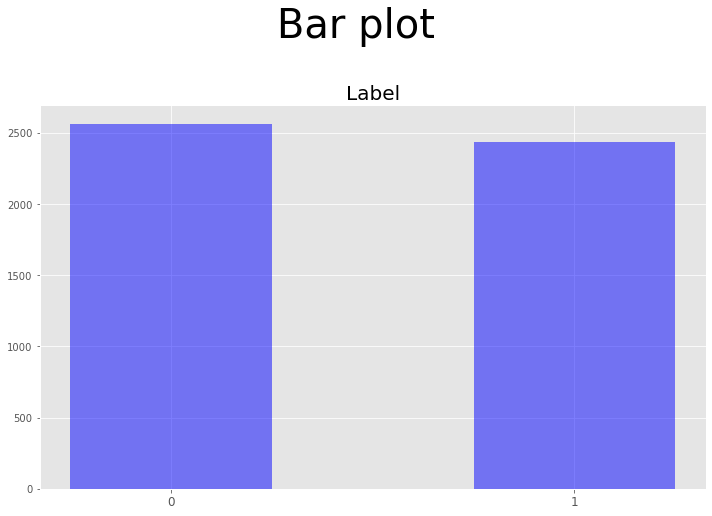

In [5]:
plt.style.use('ggplot') # 이거 아마 그래프를 R스타일?로 출력하는 코드

# Label 개수를 그래프로 그려 시각적으로 비교
feature = df['label']

plt.figure(figsize=(10, 7.5)) # 그래프 이미지 크기 설정
plt.suptitle('Bar plot', fontsize=40) # 부제목과 폰트 크기 설정
plt.title('Label', fontsize=20) # 제목과 폰트 크기 설정

temp = feature.value_counts() # feature 변수의 변수별 개수 계산
plt.bar(temp.keys(), temp.values, width=0.5, color='b', alpha=0.5) # 막대그래프 생성
plt.xticks(temp.keys(), fontsize=12) # x축 값, 폰트 크기 설정
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 레이아웃 설정
plt.show()

##### 리뷰 길이 확인

In [6]:
str_len_mean = np.mean(df['document'].str.len()) # 리뷰 길이의 평균값 계산
print('리뷰의 평균 길이:', str_len_mean)

리뷰의 평균 길이: 27.1352


##### 전체리뷰 / 긍정리뷰 / 부정리뷰의 문자열 길이 히스토그램으로

In [7]:
# 내가 전체 긍정 부정 리뷰 뽑은거
total_review = df['document']
positive_review = df[df['label'] == 1]['document']
negative_review = df[df['label'] == 0]['document']

# 데이콘 코드

# 데이터 필터링을 위한 마스크 설정
mask_pos = (df.label == 1) # 인덱싱이 이렇게도 되네? df['label'] == df.label dtype도 Serise로 동일함
mask_neg = (df.label == 0)

# 전체 / 긍정 / 부정 리뷰 집합을 설정
df_train = df.document.copy() # 전체 train 데이터
df_pos = df.loc[mask_pos,:].document # 긍정 리뷰에만 해당하는 train 데이터
df_neg = df.loc[mask_neg,:].document # 부정 리뷰에만 해당하는 train 데이터

# 세 집합을 리스트로 묶어줌
compare = [df_train, df_pos, df_neg]
# 리스트에 각 시리즈를 넣은 것

##### 긍정 / 부정 데이터셋이 잘 분리되었는지 확인

In [8]:
df_pos.head() # 긍정 데이터 확인
df_neg.head() # 부정 데이터 확인

0                  영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐
3                아무래도 20년도지난작품이라 지금보기는너무유치하다
4    지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.
6                성룡영화중 최악 .. 차라리 러시아워가 훨씬 나음
9                   결말 기분나쁘다 공포매니아에게 이따위 결말을
Name: document, dtype: object

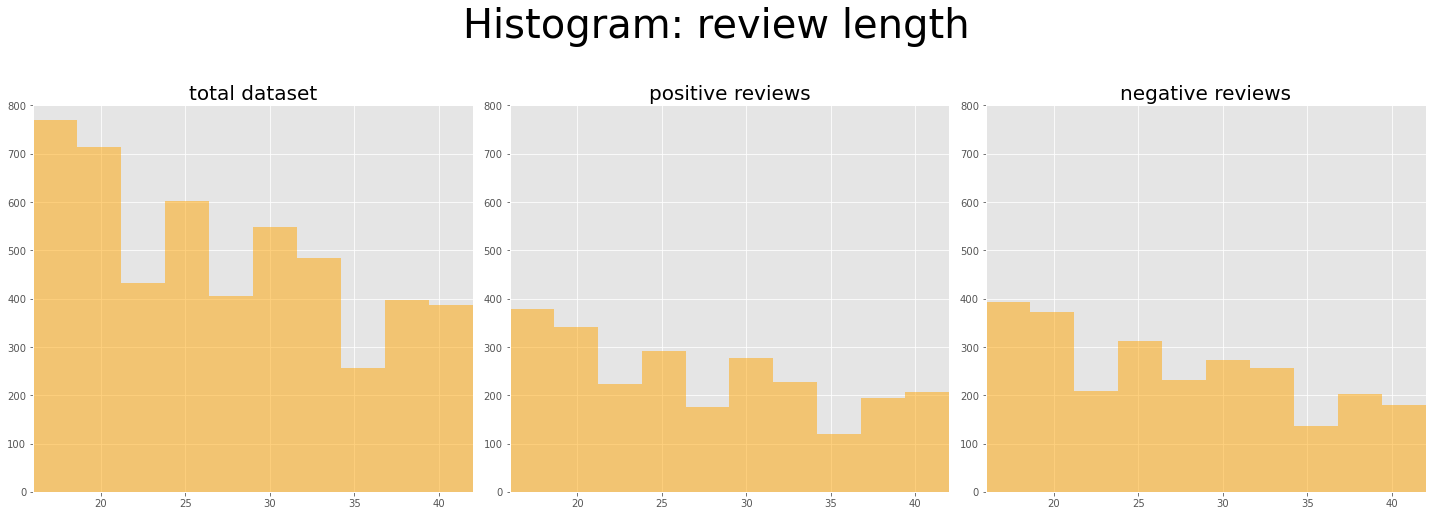

In [9]:
# 히스토그램을 사용해서 데이터의 분포 살피기
plt.figure(figsize=(20,7.5))
plt.suptitle('Histogram: review length', fontsize=40)
name = ['total dataset', 'positive reviews', 'negative reviews'] # 제목으로 사용할 문자열

for i in range(len(compare)):
    document = compare[i]
    string_len = [len(x) for x in document] # 이 문법 중요함
    plt.subplot(1,3,i+1) # 행 개수 / 열 개수 / 해당 그래프 표시 순서
    plt.title(name[i], fontsize=20)
    plt.axis([16, 42, 0, 800]) # x축 시작, 끝 / y축 시작, 끝
    plt.hist(string_len, alpha=0.5, color='orange') # 히스토그램 생성

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

* 문자열의 길이는 15_45 사이에 분포하며 대체적으로 길이가 짧아질수록 빈도수가 더 높은 것을 확인할 수 있다.
* 또한 긍정 / 부정 데이터에 상관 없이 리뷰의 길이는 비슷한 분포를 보인다.
* <span style="color: gray">가로가 문자열의 길이 세로가 빈도수인가?</span>

이번에는 띄어쓰기를 기준으로 각 리뷰 당 포함하는 어절(word) 수를 살펴본다.<br/>
다음 예시와 같이 split() 함수를 사용해 공백을 기준으로 하여 어절 단위로 문자열을 분리하는 방법을 사용한다.</br>
<span style="color: gray">띄어쓰기를 제대로 안한 리뷰는 어절을 잘 못나누겠네?</span>

In [10]:
word_split = df['document'].str.split()# 공백을 기준으로 문자열을 분리해줌
word_split[:5] # 상위 5개 값 확인

0                     [영상이나, 음악이, 이쁘다, 해도, 미화시킨, 불륜일뿐]
1                 [히치콕이, 이, 영화를, 봤다면, 분명, 박수를, 쳤을듯...]
2       [괜찮은, 음악영화가, 또, 나왔군요!!!, 따뜻한, 겨울이, 될, 것, 같아요~]
3                      [아무래도, 20년도지난작품이라, 지금보기는너무유치하다]
4    [지금까지의, 영화들이, 그랬듯., 이, 영화역시, 일본에, 대한, 미화는, 여전하다.]
Name: document, dtype: object

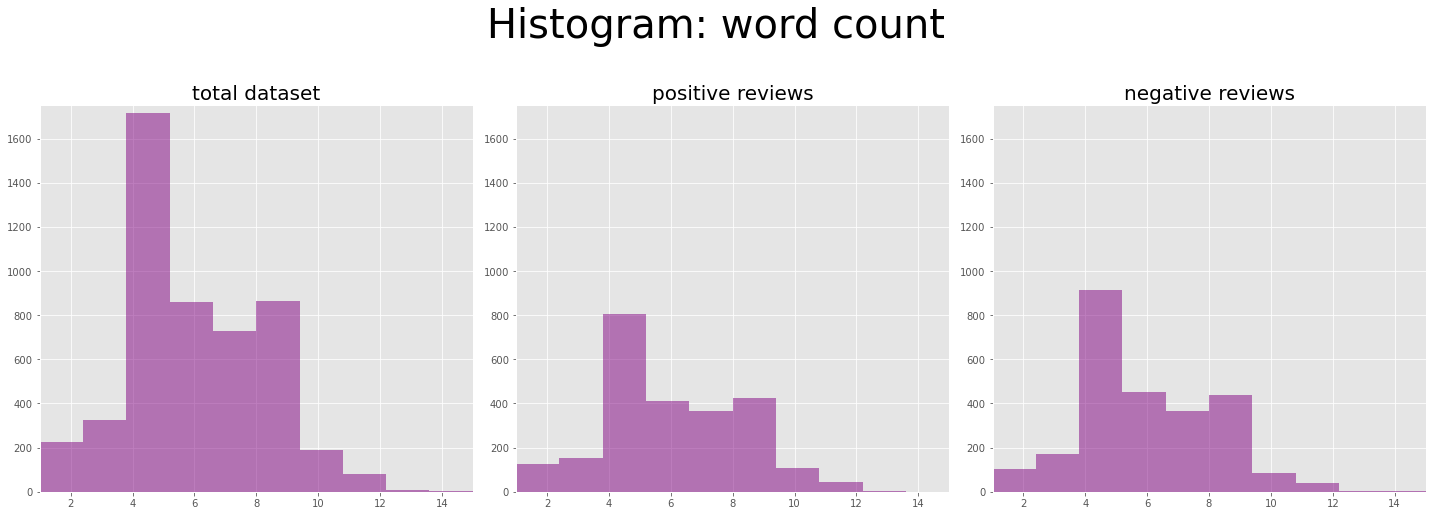

In [11]:
# 히스토그램을 사용해 데이터의 분포를 살펴봄
plt.figure(figsize=(20,7.5))
plt.suptitle('Histogram: word count', fontsize=40)
name = ['total dataset', 'positive reviews', 'negative reviews'] # 제목으로 사용할 문자열

for i in range(len(compare)):
    document = compare[i]
    split = document.str.split()
    split_len = [len(x) for x in split] # 이 문법? 중요함
    plt.subplot(1,3,i+1) # 행 개수 / 열 개수 / 해당 그래프 표시 순서
    plt.title(name[i], fontsize=20)
    plt.axis([1, 15, 0, 1750]) # x축 시작, 끝 / y축 시작, 끝
    plt.hist(split_len, alpha=0.5, color='purple')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

4 ~ 6개의 어절로 이루어진 리뷰가 가장 많은 것을 확인함<br/>
분포는 마찬가지로 세 데이터셋이 거의 동일함

<span style="color: gray">히스토그램이 연속적인 값 동안 분포?를 나타내나봄<br/>
이거 이용하면 복잡하게 실루엣점수 그래프 안그리고 조금 편하게 그리고 codeB에서 그려볼 수 있겠는데?</span>

#### Word Cloud
태그 클라우드와 동의어인 워드 클라우드는 문서의 키워드 등을 직관적으로 파악할 수 있도록 하는 시각화 기법<br/>
예를 들어, 문서에 자주 언급된 단어일수록 크게 시각화하여 문서에서 등장하는 주요 단어들을 한눈에 파악할 수 있음<br/>
이 기법은 문서 빅데이터 분석에서 자주 사용됨

#### 기본 함수 정의
워드 클라우드를 생성하기 위한 패키지를 불러오고 기본 함수들을 정의함

In [12]:
def df2str(df):
    # 전체 리뷰들을 하나의 문자열로 만듦
    s = [s for s in df]
    document = ''
    for i in range(len(s)):
        document += s[i]
    return document


'''
s = [s for s in df] => 이거는
for s in df:
    str_list = []
    str_list.append(s)
'''

def get_noun(text):
    # okt tagger를 이용해 명사 추출
    okt = Okt() # konlpy
    noun = okt.nouns(text) # 명사 추출
    for i,v in enumerate(noun):
        if len(v) < 2:
            noun.pop(i)
    count = Counter(noun)
    noun_list = count.most_common(100)

    return noun_list

def visualize(noun_list, title):
    # 워드클라우드 이미지 생성
    wc = WordCloud(
        font_path='./Font/malgun.ttf', # 한글폰트 경로 설정
        background_color='white',   # 배경색
        colormap='Dark2',    # 폰트 색깔 정하기
        width=800,
        height=800).generate_from_frequencies(dict(noun_list))
    
    plt.figure(figsize=(10,10)) # 이미지 사이즈 지정
    plt.suptitle('Word Cloud', fontsize=40)
    plt.title(title, fontsize=20)
    plt.imshow(wc, interpolation='lanczos') # 이미지의 부드럽기 정도
    plt.axis('off') # x y 축 숫자 제거
    plt.show()

    return wc

#### 전체 train 데이터 워드 클라우드 생성

In [13]:
document = df2str(df_train) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list = get_noun(document) # 명사 추출, 개수 셈
noun_list[:10] # 상위 10개 단어 확인

[('영화', 1501),
 ('정말', 320),
 ('진짜', 269),
 ('최고', 220),
 ('평점', 185),
 ('연기', 181),
 ('감동', 161),
 ('재미', 152),
 ('보고', 140),
 ('스토리', 130)]

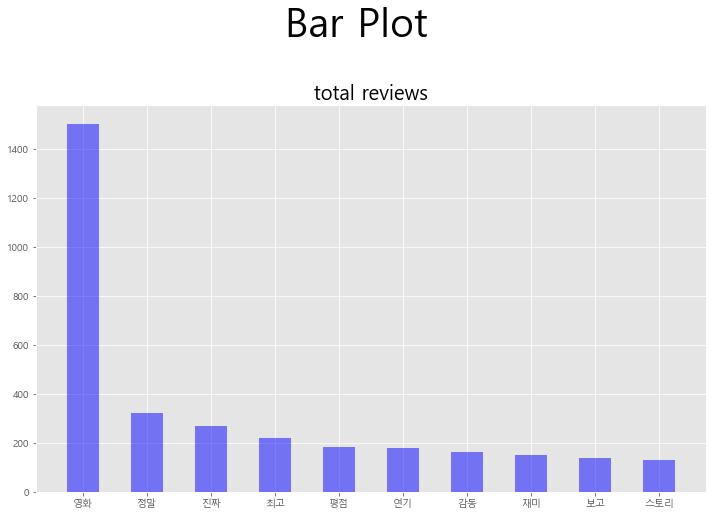

In [14]:
plt.rc('font', family='Malgun Gothic')
top_10 = dict(noun_list[:10]) # 추출한 명사 중 상위 10개
plt.figure(figsize=(10,7.5))
plt.suptitle('Bar Plot', fontsize=40)
plt.title('total reviews', fontsize=20)
plt.bar(top_10.keys(), top_10.values(), width=0.5, color='b', alpha=0.5)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

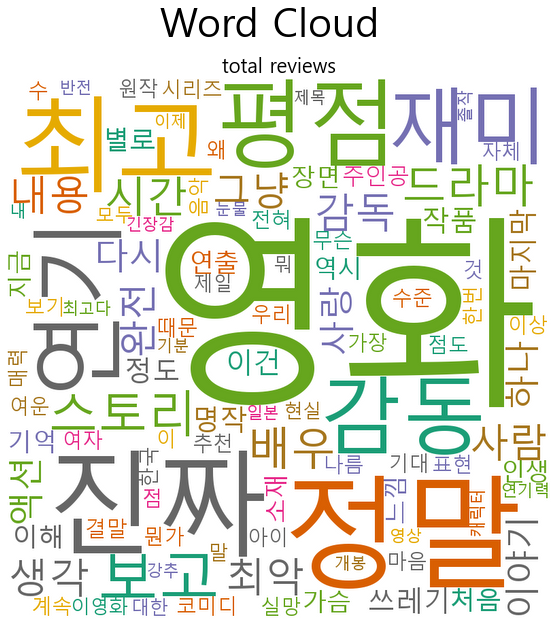

In [15]:
total_reviews = visualize(noun_list, 'total reviews') # 워드클라우드 시각화

최고, 감동 등 긍정적인 키워드와 최악, 쓰레기 등 부정적인 키워드가 혼재함을 확인할 수 있음<br>
이번에는 긍정, 부정리뷰 별 키워드를 각각 확인

#### 긍정 리뷰 워드클라우드 생성

In [16]:
document_p = df2str(df_pos) # 긍정 리뷰 데이터프레임을 하나의 큰 문자열로 만듦
noun_list_p = get_noun(document_p)
noun_list_p[:10] # 상위 10개 확인

[('영화', 757),
 ('정말', 216),
 ('최고', 214),
 ('진짜', 136),
 ('감동', 134),
 ('연기', 108),
 ('드라마', 89),
 ('보고', 88),
 ('사랑', 72),
 ('다시', 70)]

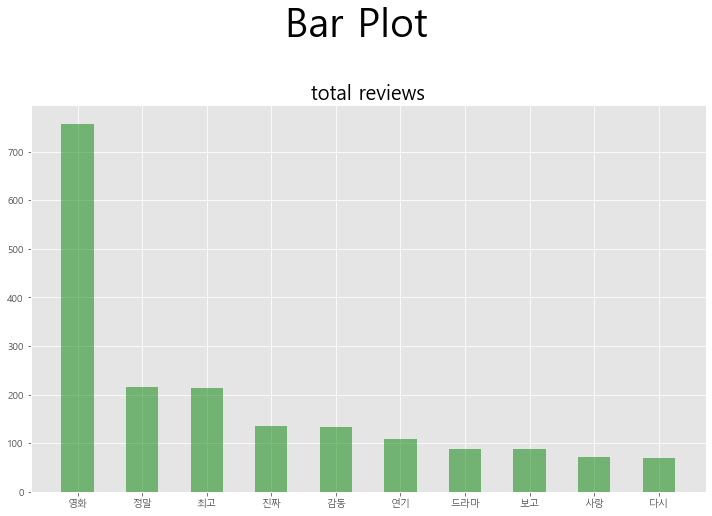

In [17]:
plt.rc('font', family='Malgun Gothic')
top_10 = dict(noun_list_p[:10])
plt.figure(figsize=(10,7.5))
plt.suptitle('Bar Plot', fontsize=40)
plt.title('total reviews', fontsize=20)
plt.bar(top_10.keys(), top_10.values(), width=0.5, color='green', alpha=0.5)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

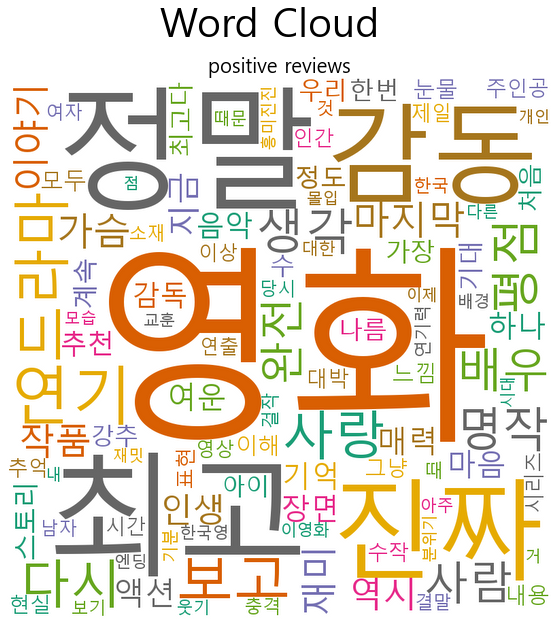

In [18]:
positive_reviews = visualize(noun_list_p, 'positive reviews') # 워드클라우드 시각화

#### 부정 리뷰

In [19]:
document_n = df2str(df_neg) # 부정 리뷰 데이터프레임을 하나의 큰 문자열로 만듦
noun_list_n = get_noun(document_n) # 명사만 추출하고 빈도수 계산
noun_list_n[:10] # 상위 10개만 확인

[('영화', 746),
 ('진짜', 132),
 ('평점', 118),
 ('재미', 104),
 ('정말', 104),
 ('스토리', 102),
 ('최악', 98),
 ('시간', 97),
 ('내용', 85),
 ('감독', 78)]

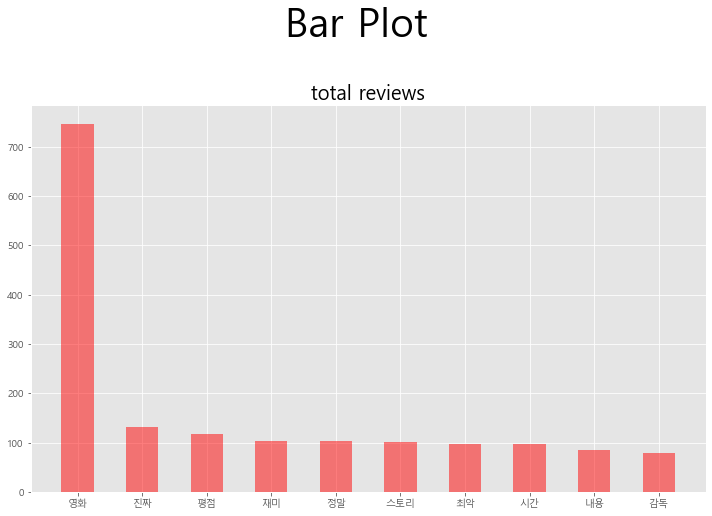

In [20]:
top_10 = dict(noun_list_n[:10])
plt.figure(figsize=(10,7.5))
plt.suptitle('Bar Plot', fontsize=40)
plt.title('total reviews', fontsize=20)
plt.bar(top_10.keys(), top_10.values(), width=0.5, color='r', alpha=0.5)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

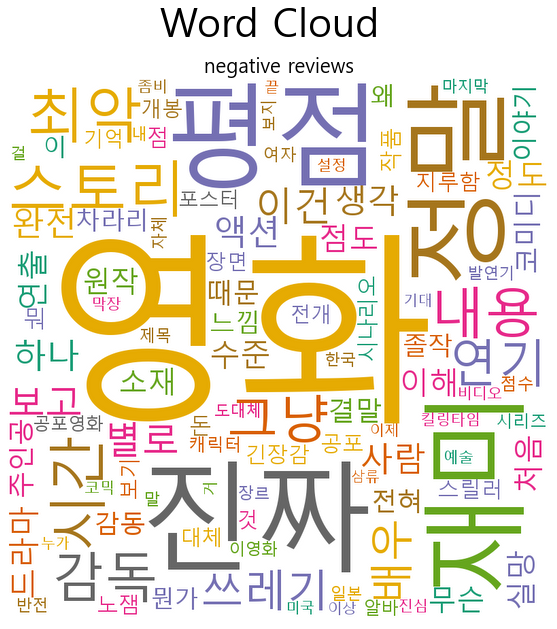

In [21]:
negative_reviews = visualize(noun_list_n, 'negative reviews') # 워드클라우드 시각화

#### 중복 단어 제거하기

위 워드클라우드를 보면 '영화', '진짜', '정말'과 같이 긍정 부정 리뷰 모두 등장하는 단어들이 존재<br>
이러한 문제를 해결하기 위해 긍정, 부정 리뷰에 공통적으로 등장하는 단어들을 제거한 뒤 다시 시각화

In [22]:
print('부정 리뷰 Top10:', noun_list_n[:10])
print('긍정 리뷰 Top10:', noun_list_p[:10])

부정 리뷰 Top10: [('영화', 746), ('진짜', 132), ('평점', 118), ('재미', 104), ('정말', 104), ('스토리', 102), ('최악', 98), ('시간', 97), ('내용', 85), ('감독', 78)]
긍정 리뷰 Top10: [('영화', 757), ('정말', 216), ('최고', 214), ('진짜', 136), ('감동', 134), ('연기', 108), ('드라마', 89), ('보고', 88), ('사랑', 72), ('다시', 70)]


In [23]:
neg = list(dict(noun_list_n).keys()) # key(명사) 만을 이용해 리스트 생성
pos = list(dict(noun_list_p).keys())

drop_words = [x for x in neg if x in pos] # 부정리뷰에 포함된 명사가 긍정리뷰에도 등장할 경우 drop_list에 저장
print('공통으로 등장하는 단어들 Top10\n', drop_words[:10])

공통으로 등장하는 단어들 Top10
 ['영화', '진짜', '평점', '재미', '정말', '스토리', '시간', '내용', '감독', '그냥']


다음으로 해당 단어들을 각각 단어 리스트에서 제거

In [24]:
noun_list_n_filter = [x for x in noun_list_n if x[0] not in drop_words] # drop_words 리스트에 포함되지 않은 부정리뷰 명사를 저장
noun_list_p_filter = [x for x in noun_list_p if x[0] not in drop_words]

print('정제된 부정 리뷰 상위 단어 Top10\n', noun_list_n_filter[:10])
print('정제된 긍정 리뷰 상위 단어 Top10\n', noun_list_p_filter[:10])

정제된 부정 리뷰 상위 단어 Top10
 [('최악', 98), ('쓰레기', 70), ('이건', 55), ('별로', 53), ('실망', 36), ('수준', 36), ('점도', 34), ('원작', 31), ('무슨', 31), ('코미디', 29)]
정제된 긍정 리뷰 상위 단어 Top10
 [('최고', 214), ('사랑', 72), ('다시', 70), ('명작', 60), ('가슴', 51), ('역시', 44), ('인생', 41), ('지금', 39), ('매력', 35), ('마음', 34)]


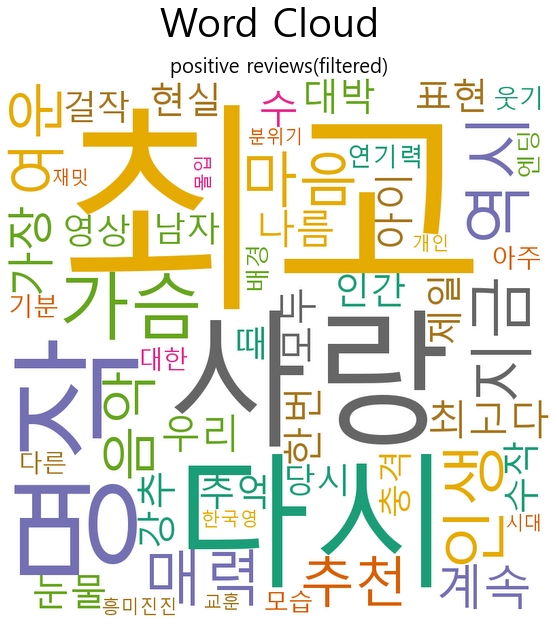

In [25]:
positive_reviews_filtered = visualize(noun_list_p_filter, 'positive reviews(filtered)')

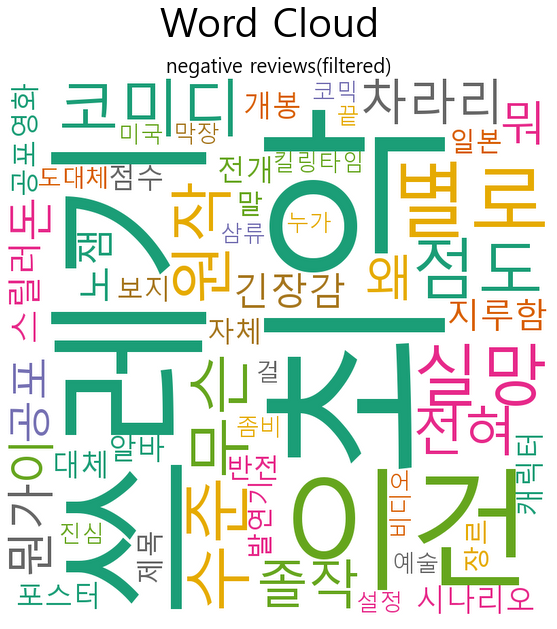

In [26]:
negative_reviews_filtered = visualize(noun_list_n_filter, 'negative reviews(filtered)')

긍정 부정 라벨에 따라 등장하는 단어가 카테고리에 잘 분리되었음<br>
이제 데이터를 둘러보는 작업은 마무리